In [178]:
import numpy as np

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        
        print(f"y : {self.y}, x : {self.x}")
        print(f"xy : {self.y*self.x}")
        return self.x * self.y

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy
    

In [2]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(mul_apple_layer.x, mul_apple_layer.y)
print(mul_tax_layer.x, mul_tax_layer.y)
print(apple_price, price)

y : 2, x : 100
xy : 200
y : 1.1, x : 200
xy : 220.00000000000003
100 2
200 1.1
200 220.00000000000003


In [3]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


In [4]:
class AddLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        
        return self.x + self.y

    def backward(self, dout):
        dx = dout
        dy = dout
        
        return dx, dy

In [5]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)


y : 2, x : 100
xy : 200
y : 3, x : 150
xy : 450
y : 1.1, x : 650
xy : 715.0000000000001
715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


In [6]:
class ReLU:
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        self.x = x
        return (x > 0)*x
    
    def backward(self, dout):
        return dout*(self.x > 0).astype(int)
    

In [7]:
class Sigmoid:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x):
        self.x = x
        self.y = 1 / (1 + np.exp(-self.x))
        return self.y
    
    def backward(self, dout):
        return dout * self.y *(1 - self.y)

In [8]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.X = None 
        
    def forward(self, X):
        self.X = X        
        return np.dot(X, self.W) + self.b
    
    def backward(self, dz):
        grads = {}
        grads["W"] = np.dot(self.X.T, dz)
        grads["X"] = np.dot(dz, self.W.T)
        grads["b"] = np.sum(dz, axis=0)
        
        return grads

In [9]:
from util import softmax, CEE

class Softmax_with_Loss:
    def __init__(self):
        self.y = None
        self.t = None
        
    def forward(self, X, t):
        self.y = softmax(X)
        self.t = t
        loss = CEE(self.y, self.t)
        
        return loss
    
    def backward(self):
        return (self.y - self.t)/self.t.shape[0]

In [10]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        # layer 1
        self.params["W1"] = 0.01 * np.random.randn(input_size,hidden_size)
        self.params["B1"] = 0.01 * np.random.randn(hidden_size)
        #layer 2
        self.params["W2"] = 0.01 * np.random.randn(hidden_size,output_size)
        self.params["B2"] = 0.01 * np.random.randn(output_size)
        
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X):
        h = self.layer["Affine1"].forward(X)
        h = self.layer["ReLU1"].forward(h)
        y = self.layer["Affine2"].forward(h)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        Y = self.predict(x)
        predict_label = np.argmax(Y, axis=1)
        target_label = np.argmax(t, axis=1)
        return np.sum(predict_label == target_label) / len(predict_label)
    
    def numerical_gradient(self, x, t):
        grads = {}

        for key in self.params:
            original_param = self.params[key]

            def loss_func(param):
                self.params[key][...] = param
                y = self.predict(x)
                return self.last_layer.forward(y, t)

            h = 1e-4
            shape = original_param.shape
            param_flat = original_param.reshape(-1)
            grad = np.zeros_like(param_flat)

            for i in range(len(param_flat)):
                tmp_val = param_flat[i]

                param_flat[i] = tmp_val + h
                fxh1 = loss_func(param_flat.reshape(shape))

                param_flat[i] = tmp_val - h
                fxh2 = loss_func(param_flat.reshape(shape))

                grad[i] = (fxh1 - fxh2) / (2 * h)

                param_flat[i] = tmp_val

            grads[key] = grad.reshape(shape)
            #self.params[key] = original_param
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t)
        grads = {}
        
        dout = self.last_layer.backward()
        temp_grads = self.layer["Affine2"].backward(dout)
        grads["W2"] = temp_grads["W"]
        grads["B2"] = temp_grads["b"]
        dout = temp_grads["X"]
        
        dout = self.layer["ReLU1"].backward(dout)
        
        temp_grads = self.layer["Affine1"].backward(dout)
        grads["W1"] = temp_grads["W"]
        grads["B1"] = temp_grads["b"]
        
        return grads

In [11]:
#import numpy as np
#from dataset.mnist import load_mnist
#
#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
#
#network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
#
#x_batch = x_train[:3]
#t_batch = t_train[:3]
#
#grad_numerical = network.numerical_gradient(x_batch, t_batch)
#grad_backprop = network.gradient(x_batch, t_batch)
#
#for key in grad_numerical.keys():
#    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
#    print(key + ":" + str(diff))

In [12]:
import numpy as np
from dataset.mnist import load_mnist
from math import ceil

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

iter_per_epoch = ceil(train_size / batch_size)
epochs_num = ceil(iters_num / iter_per_epoch)

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

cur_iter = 1
for epoch in range(epochs_num):
    # 셔플
    x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
    offset = 0

    # 배치 수
    for i in range(iter_per_epoch):
        if cur_iter > iters_num:
            break  # iteration 수를 채우면 종료

        # 미니배치 추출
        x_batch = x_train_shuffled[offset:offset+batch_size]
        t_batch = t_train_shuffled[offset:offset+batch_size]

        grads = network.gradient(x_batch, t_batch)
        loss = network.loss(x_batch, t_batch)
        if cur_iter%100 == 0:
            print(f"| epoch {epoch} | iter {cur_iter}/{iters_num} | loss: {loss:.4f} |")

        for key in network.params.keys():
            network.params[key] -= lr * grads[key]

        train_loss_list.append(loss)
        cur_iter += 1
        offset += batch_size
    
    train_accuracy = network.accuracy(x_train, t_train)
    train_accuracy_list.append(train_accuracy)
    test_accuracy = network.accuracy(x_test, t_test)
    test_accuracy_list.append(test_accuracy)
    print(f"====== train accuracy : {train_accuracy} / test accuracy : {test_accuracy} ======")
    
    if cur_iter > iters_num:
        break  # 에폭 루프도 종료
    

| epoch 0 | iter 100/10000 | loss: 1.1749 |
| epoch 0 | iter 200/10000 | loss: 0.4560 |
| epoch 0 | iter 300/10000 | loss: 0.4369 |
| epoch 0 | iter 400/10000 | loss: 0.3215 |
| epoch 0 | iter 500/10000 | loss: 0.3171 |
| epoch 0 | iter 600/10000 | loss: 0.3035 |
====== train accuracy : 0.903 / test accuracy : 0.9051 ======
| epoch 1 | iter 700/10000 | loss: 0.4731 |
| epoch 1 | iter 800/10000 | loss: 0.3806 |
| epoch 1 | iter 900/10000 | loss: 0.2310 |
| epoch 1 | iter 1000/10000 | loss: 0.2794 |
| epoch 1 | iter 1100/10000 | loss: 0.3304 |
| epoch 1 | iter 1200/10000 | loss: 0.4196 |
====== train accuracy : 0.9232166666666667 / test accuracy : 0.926 ======
| epoch 2 | iter 1300/10000 | loss: 0.3516 |
| epoch 2 | iter 1400/10000 | loss: 0.3193 |
| epoch 2 | iter 1500/10000 | loss: 0.2006 |
| epoch 2 | iter 1600/10000 | loss: 0.3192 |
| epoch 2 | iter 1700/10000 | loss: 0.2201 |
| epoch 2 | iter 1800/10000 | loss: 0.2115 |
====== train accuracy : 0.9349333333333333 / test accuracy : 0.

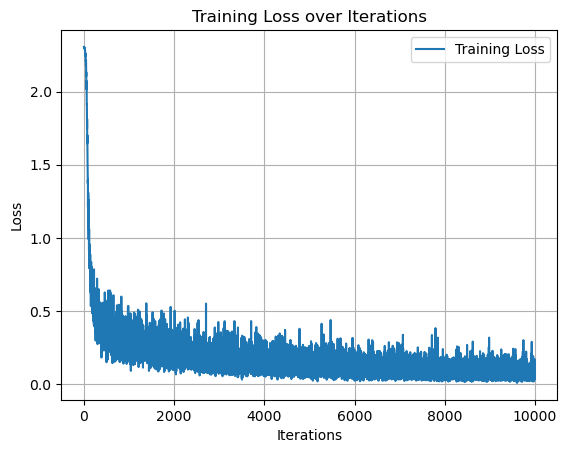

In [191]:
import matplotlib.pyplot as plt

# 학습 손실 시각화
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.grid(True)
plt.show()

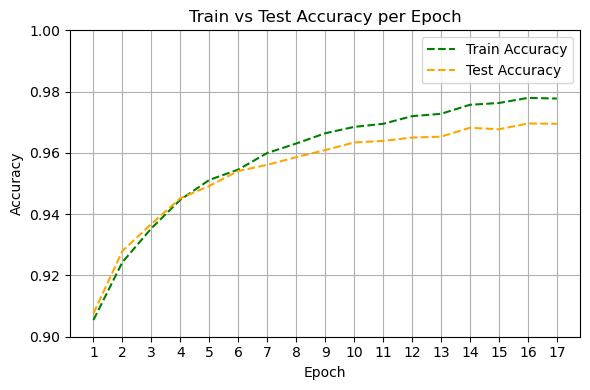

In [192]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, len(train_accuracy_list) + 1)

plt.figure(figsize=(6, 4))

plt.plot(x, train_accuracy_list, label='Train Accuracy', linestyle='--', color='green')
plt.plot(x, test_accuracy_list, label='Test Accuracy', linestyle='--', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy per Epoch')
plt.ylim(0.9, 1)
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
